In [ ]:
### Imports ###
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
# from keras.engine.topology import Container
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.initializers import he_uniform
from keras.backend.tensorflow_backend import set_session

import matplotlib.pyplot as plt

import cv2
import numpy as np
import os
import random
import scipy.misc
import scipy.io as sio
from tqdm import *
import pywt
import pywt.data
from pywt import dwt2, idwt2
import imageio
# from attention_module import attach_attention_module
from skimage import color
import skimage

%matplotlib inline

In [ ]:
### Constants ###
LFW_DIR = "../data/lfw/lfw"  #250*250
IMG_SHAPE = 250

In [ ]:
def load_dataset_lfw(num_images=2000):
    X_cover = []
    X_secret = []
    for c in os.listdir(LFW_DIR): 
        c_dir = os.path.join(LFW_DIR, c) 
        c_imgs = os.listdir(c_dir) 
        #random.shuffle(c_imgs)
        for img_name_i in c_imgs: 
            if len(X_cover)<num_images:
                img_i = image.load_img(os.path.join(c_dir, img_name_i)) #load RGB cover image
                x = image.img_to_array(img_i) 
                x = x[0:IMG_SHAPE,0:IMG_SHAPE,:]
                X_cover.append(x)
            elif len(X_secret)<num_images:
                img_i = image.load_img(os.path.join(c_dir, img_name_i)).convert("L") #load gray secret image
                x = image.img_to_array(img_i) 
                x = x[0:IMG_SHAPE,0:IMG_SHAPE,:]
                X_secret.append(x) 
            else :
                break
    random.shuffle(X_cover)
    random.shuffle(X_secret)
    return np.array(X_cover), np.array(X_secret)

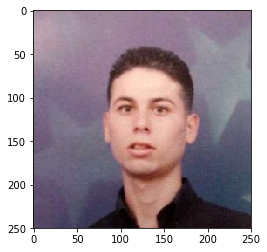

In [ ]:
# Load dataset.
X_cover, X_secret = load_dataset_lfw()

# Normalize cover images.
X_cover = X_cover /255 
img1 =  np.zeros(shape=(IMG_SHAPE,IMG_SHAPE))
img1 = X_cover[1,:,:] #show a cover image
plt.imshow(img1)
plt.show()

In [ ]:
X_cover_b = X_cover[:,:,:,2:3]
print ("Number of cover examples = " + str(X_cover.shape))
print ("X_cover_b shape: " + str(X_cover_b.shape)) # Should be (train_size, 250, 250, 3).

Number of cover examples = (2000, 250, 250, 3)
X_cover_l shape: (2000, 250, 250, 1)


X_secret_shape: (2000, 250, 250, 1)


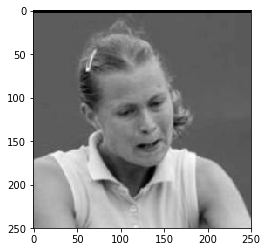

In [ ]:
# Normalize secret images.
X_secret = X_secret/255
print ("X_secret_shape: " + str(X_secret.shape))

#show a secret image
img2 =  np.zeros(shape=(IMG_SHAPE,IMG_SHAPE))
img2 = X_secret[1,:,:,0]
plt.imshow(img2,cmap ='gray') 
plt.show()

In [ ]:
#show the range of image values
print("Cover_b min:"+str(X_cover_b.min())+" Cover_b max"+str(X_cover_b.max()))
print("X_secret_test min:"+str(X_secret.min())+" X_secret_test max"+str(X_secret.max()))

Cover_b min:0.0 Cover_b max1.0
X_secret_test min:0.0 X_secret_test max1.0


In [ ]:
# Discrete wavelet transform
X_cover_b2 = np.zeros(shape=(X_cover_b.shape[0],155,155,4)) 
X_secret2 = np.zeros(shape=(X_secret.shape[0],155,155,4))
for i in range(X_cover_b.shape[0]): 
    x=np.reshape(X_cover_b[i],(IMG_SHAPE,IMG_SHAPE))
    coeffs = dwt2(x,'dmey')
    cA,(cH, cV, cD) = coeffs
    X_cover_b2[i,:,:,0]=cA
    X_cover_b2[i,:,:,1]=cH
    X_cover_b2[i,:,:,2]=cV
    X_cover_b2[i,:,:,3]=cD
    
for i in range(X_secret.shape[0]): 
    x=np.reshape(X_secret[i],(IMG_SHAPE,IMG_SHAPE))
    coeffs = dwt2(x,'dmey')
    cA,(cH, cV, cD) = coeffs
    X_secret2[i,:,:,0]=cA
    X_secret2[i,:,:,1]=cH
    X_secret2[i,:,:,2]=cV
    X_secret2[i,:,:,3]=cD

In [ ]:
# C: cover image
input_C = X_cover_b2[0:X_cover_b.shape[0],:,:,3:4]  #高频
# S: secret image
input_S = X_secret2[0:X_secret.shape[0]] 
print(np.shape(input_C))
print(np.shape(input_S))

(2000, 155, 155, 1)
(2000, 155, 155, 4)


In [ ]:
beta = 1.0
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))
    

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:4], y_true[...,4:5] 
    s_pred, c_pred = y_pred[...,0:4], y_pred[...,4:5]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


def make_encoder(input_size_s,input_size_c):
    input_S = Input(shape=(input_size_s)) 
    input_C= Input(shape=(input_size_c))
    # Preparation Network

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    #Output high frequency sub-band of stego image 
    output_Cprime = Conv2D(1, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Function that applies the noise layer to the image（we dont use it in final model）
def make_noise_model(input_size,name):
    noise_input = Input(shape=(input_size))

    # choose one of noise input
    if name == "identity":
        return Model(inputs=noise_input, outputs=noise_input, name='noise')
    elif name == "gaussian":
        input_with_noise = GaussianNoise(0.1, name='output_C_noise')(noise_input)
        return Model(inputs=noise_input, outputs=input_with_noise, name='noise')
    elif name == "dropout":
        input_with_noise = Dropout(0.1)(noise_input)
        return Model(inputs=noise_input, outputs=input_with_noise, name='noise')
    
    
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    # Adding Gaussian noise with 0.01 standard deviation.
#     input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(reveal_input)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(reveal_input)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(reveal_input)
    x = concatenate([x3, x4, x5])
    #output the frequency sub-bands of revealed secret image
    output_Sprime = Conv2D(4, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size_s,input_size_c,name):
    input_S = Input(shape=(input_size_s))
    input_C = Input(shape=(input_size_c))
    encoder = make_encoder(input_size_s,input_size_c)
    noise_model = make_noise_model(input_size_c,name) 

    decoder = make_decoder(input_size_c)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False 
    
    output_Cprime = encoder([input_S, input_C])
    input_with_noise = noise_model(output_Cprime)
    output_Sprime = decoder(input_with_noise)
    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, noise_model, decoder, autoencoder

In [ ]:
encoder_model, noise_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:],input_C.shape[1:],"identity")

In [ ]:
autoencoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 155, 155, 4)  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 155, 155, 1)  0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 155, 155, 1)  100006      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
noise (Model)                   (None, 155, 155, 1)  0           Encoder[1][0]                    
__________

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 150: 
        return 0.001 
    elif epoch_idx < 300: 
        return 0.0003
    else:
        return 0.0001

In [ ]:
NB_EPOCHS = 400
BATCH_SIZE = 16

m = input_S.shape[0]
loss_history = []
loss_rev_history = []

for epoch in range(NB_EPOCHS): 
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        C_prime = encoder_model.predict([batch_S, batch_C])    
#         C_with_noise = noise_model.predict(C_prime)
        S_prime = reveal_model.predict(C_prime)
        #train_on_batch
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))
    loss_rev_history.append(np.mean(rev_loss))
#    if (epoch+1)%10==0:
#        img=C_prime[0]
#        c_pred_A=img[:,:,0]
#        c_pred_H=img[:,:,1]
#        c_pred_V=img[:,:,2]
#        c_pred_D=img[:,:,3]
#        c_pred_s=idwt2((c_pred_A,(c_pred_H,c_pred_V,c_pred_D)),'bior3.7')
#        imageio.imwrite('out1/bossbase_result_C_%s.bmp'%((epoch+1)/10), c_pred_s)
#        img2=S_prime[0]
#        s_pred_A=img2[:,:,0]
#        s_pred_H=img2[:,:,1]
#        s_pred_V=img2[:,:,2]
#        s_pred_D=img2[:,:,3]
#        s_pred_s=idwt2((s_pred_A,(s_pred_H,s_pred_V,s_pred_D)),'bior3.7')
#        imageio.imwrite('out1/bossbase_result_S_%s.bmp'%((epoch+1)/10), s_pred_s)
#         sio.savemat('out/bossbase_result_C_%s.mat'%((epoch)/20),{'image1':img})

Epoch 1 | Batch: 1984 of 2000. Loss AE   50750.77 | Loss Rev   40252.75: 100%|██████████| 125/125 [00:42<00:00,  2.92it/s]
Epoch 2 | Batch: 1984 of 2000. Loss AE    5053.34 | Loss Rev    2776.71: 100%|██████████| 125/125 [00:39<00:00,  3.14it/s]
Epoch 3 | Batch: 1984 of 2000. Loss AE    3448.52 | Loss Rev    2119.80: 100%|██████████| 125/125 [00:40<00:00,  3.12it/s]
Epoch 4 | Batch: 1984 of 2000. Loss AE    2878.62 | Loss Rev    1882.63: 100%|██████████| 125/125 [00:40<00:00,  3.12it/s]
Epoch 5 | Batch: 1984 of 2000. Loss AE    2276.29 | Loss Rev    1439.51: 100%|██████████| 125/125 [00:40<00:00,  3.11it/s]
Epoch 6 | Batch: 1984 of 2000. Loss AE    2035.42 | Loss Rev    1309.63: 100%|██████████| 125/125 [00:40<00:00,  3.09it/s]
Epoch 7 | Batch: 1984 of 2000. Loss AE    3310.09 | Loss Rev    2660.87: 100%|██████████| 125/125 [00:40<00:00,  3.09it/s]
Epoch 8 | Batch: 1984 of 2000. Loss AE    1757.80 | Loss Rev    1135.94: 100%|██████████| 125/125 [00:40<00:00,  3.10it/s]
Epoch 9 | Batch:

Epoch 67 | Batch: 1984 of 2000. Loss AE     481.43 | Loss Rev     362.06: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]
Epoch 68 | Batch: 1984 of 2000. Loss AE     498.29 | Loss Rev     380.68: 100%|██████████| 125/125 [00:39<00:00,  3.17it/s]
Epoch 69 | Batch: 1984 of 2000. Loss AE     524.34 | Loss Rev     408.42: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]
Epoch 70 | Batch: 1984 of 2000. Loss AE     486.21 | Loss Rev     371.65: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]
Epoch 71 | Batch: 1984 of 2000. Loss AE     504.50 | Loss Rev     391.49: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]
Epoch 72 | Batch: 1984 of 2000. Loss AE     476.74 | Loss Rev     365.18: 100%|██████████| 125/125 [00:39<00:00,  3.18it/s]
Epoch 73 | Batch: 1984 of 2000. Loss AE     513.58 | Loss Rev     403.46: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 74 | Batch: 1984 of 2000. Loss AE     477.71 | Loss Rev     369.29: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]
Epoch 75

Epoch 132 | Batch: 1984 of 2000. Loss AE     393.00 | Loss Rev     318.54: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 133 | Batch: 1984 of 2000. Loss AE     397.89 | Loss Rev     324.02: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 134 | Batch: 1984 of 2000. Loss AE     391.40 | Loss Rev     318.42: 100%|██████████| 125/125 [00:39<00:00,  3.18it/s]
Epoch 135 | Batch: 1984 of 2000. Loss AE     392.93 | Loss Rev     320.67: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 136 | Batch: 1984 of 2000. Loss AE     394.38 | Loss Rev     322.69: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 137 | Batch: 1984 of 2000. Loss AE     408.08 | Loss Rev     337.21: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
Epoch 138 | Batch: 1984 of 2000. Loss AE     400.95 | Loss Rev     330.72: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
Epoch 139 | Batch: 1984 of 2000. Loss AE     432.74 | Loss Rev     363.34: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]


Epoch 197 | Batch: 1984 of 2000. Loss AE     347.54 | Loss Rev     299.44: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 198 | Batch: 1984 of 2000. Loss AE     347.47 | Loss Rev     299.67: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 199 | Batch: 1984 of 2000. Loss AE     351.62 | Loss Rev     304.09: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 200 | Batch: 1984 of 2000. Loss AE     356.26 | Loss Rev     309.04: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]
Epoch 201 | Batch: 1984 of 2000. Loss AE     347.09 | Loss Rev     300.09: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 202 | Batch: 1984 of 2000. Loss AE     350.28 | Loss Rev     303.54: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
Epoch 203 | Batch: 1984 of 2000. Loss AE     346.32 | Loss Rev     299.75: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 204 | Batch: 1984 of 2000. Loss AE     358.83 | Loss Rev     312.68: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]


Epoch 262 | Batch: 1984 of 2000. Loss AE     339.24 | Loss Rev     302.33: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 263 | Batch: 1984 of 2000. Loss AE     342.85 | Loss Rev     306.08: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 264 | Batch: 1984 of 2000. Loss AE     333.98 | Loss Rev     297.29: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 265 | Batch: 1984 of 2000. Loss AE     341.16 | Loss Rev     304.64: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
Epoch 266 | Batch: 1984 of 2000. Loss AE     338.63 | Loss Rev     302.14: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 267 | Batch: 1984 of 2000. Loss AE     338.75 | Loss Rev     302.34: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 268 | Batch: 1984 of 2000. Loss AE     335.91 | Loss Rev     299.59: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
Epoch 269 | Batch: 1984 of 2000. Loss AE     350.02 | Loss Rev     313.79: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]


Epoch 327 | Batch: 1984 of 2000. Loss AE     330.11 | Loss Rev     298.18: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 328 | Batch: 1984 of 2000. Loss AE     327.88 | Loss Rev     295.98: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 329 | Batch: 1984 of 2000. Loss AE     328.40 | Loss Rev     296.59: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]
Epoch 330 | Batch: 1984 of 2000. Loss AE     329.59 | Loss Rev     297.83: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 331 | Batch: 1984 of 2000. Loss AE     328.06 | Loss Rev     296.35: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 332 | Batch: 1984 of 2000. Loss AE     327.89 | Loss Rev     296.26: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
Epoch 333 | Batch: 1984 of 2000. Loss AE     327.78 | Loss Rev     296.20: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
Epoch 334 | Batch: 1984 of 2000. Loss AE     328.29 | Loss Rev     296.79: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]


Epoch 392 | Batch: 1984 of 2000. Loss AE     324.84 | Loss Rev     296.27: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 393 | Batch: 1984 of 2000. Loss AE     325.19 | Loss Rev     296.65: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 394 | Batch: 1984 of 2000. Loss AE     324.69 | Loss Rev     296.19: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]
Epoch 395 | Batch: 1984 of 2000. Loss AE     324.52 | Loss Rev     296.06: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]
Epoch 396 | Batch: 1984 of 2000. Loss AE     325.52 | Loss Rev     297.11: 100%|██████████| 125/125 [00:38<00:00,  3.23it/s]
Epoch 397 | Batch: 1984 of 2000. Loss AE     324.16 | Loss Rev     295.75: 100%|██████████| 125/125 [00:39<00:00,  3.20it/s]
Epoch 398 | Batch: 1984 of 2000. Loss AE     328.19 | Loss Rev     299.85: 100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
Epoch 399 | Batch: 1984 of 2000. Loss AE     323.91 | Loss Rev     295.61: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]


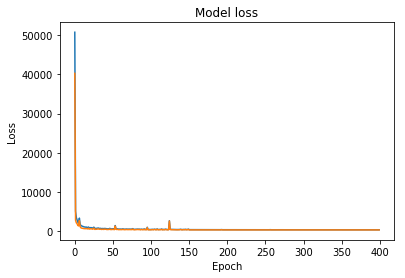

In [ ]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_rev_history)
# plt.title('Rev loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
plt.show()
#AE loss，REV loss

In [ ]:
# Save model
autoencoder_model.save_weights('RGB-high-lfw-0817.hdf5')

In [ ]:
# Load model
autoencoder_model.load_weights('model-LAB-high3-4000.hdf5')

In [ ]:
#TEST
# Load test dataset.
X_cover_test, X_secret_test = load_dataset_lfw(200)

# Normalize test image vectors.
X_cover_test = X_cover_test / 255
X_cover_b_test = X_cover_test[:,:,:,2:3]

X_secret_test = X_secret_test/255
print ("X_cover_b shape: " + str(X_cover_b_test.shape)) # Should be (train_size, 263, 263, 4).
print ("X_secret shape: " + str(X_secret_test.shape))


X_cover_b shape: (200, 250, 250, 1)
X_secret shape: (200, 250, 250, 1)


In [ ]:
print("Cover_b min:"+str(X_cover_b_test.min())+" Cover_b max"+str(X_cover_b_test.max()))
print("X_secret_test min:"+str(X_secret_test.min())+" X_secret_test max"+str(X_secret_test.max()))

Cover_b min:0.0 Cover_b max1.0
X_secret_test min:0.0 X_secret_test max1.0


In [ ]:
# Discrete wavelet transform
X_cover_b2 = np.zeros(shape=(X_cover_b_test.shape[0],155,155,4))
X_secret2 = np.zeros(shape=(X_secret_test.shape[0],155,155,4))
for i in range(X_cover_b_test.shape[0]): 
    x=np.reshape(X_cover_b_test[i],(IMG_SHAPE,IMG_SHAPE))
    coeffs = dwt2(x,'dmey') 
    cA,(cH, cV, cD) = coeffs
    X_cover_b2[i,:,:,0]=cA
    X_cover_b2[i,:,:,1]=cH
    X_cover_b2[i,:,:,2]=cV
    X_cover_b2[i,:,:,3]=cD
    
for i in range(X_secret_test.shape[0]):
    x=np.reshape(X_secret_test[i],(IMG_SHAPE,IMG_SHAPE))
    coeffs = dwt2(x,'dmey')
    cA,(cH, cV, cD) = coeffs
    X_secret2[i,:,:,0]=cA
    X_secret2[i,:,:,1]=cH
    X_secret2[i,:,:,2]=cV
    X_secret2[i,:,:,3]=cD

# C: cover image
input_C = X_cover_b2[0:X_cover_b_test.shape[0],:,:,3:4] #取高频
# S: secret image
input_S = X_secret2[0:X_secret_test.shape[0]] 
print("shape of dwt data")
print(np.shape(input_C))
print(np.shape(input_S))   

shape of dwt data
(200, 155, 155, 1)
(200, 155, 155, 4)


In [ ]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
# C_with_noise = noise_model.predict(decoded_C)
# Get absolute difference between the outputs and the expected values.

In [ ]:
decoded_S, decoded_C = decoded[...,0:4], decoded[...,4:5]
decoded_C = np.concatenate((X_cover_b2[0:X_cover_b_test.shape[0],:,:,0:3],decoded_C), axis=3)
#decoded_C = np.concatenate((decoded_C,X_cover_l2[0:X_cover_l.shape[0],:,:,1:4]), axis=3)
print(np.shape(decoded_C))

(200, 155, 155, 4)


In [ ]:
def pixel_errors(X_secret, X_cover, decoded_S, decoded_C): #MSE
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """      
    see_Spixel = np.sqrt(np.mean(np.square((X_secret - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square((X_cover - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C): 
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten() 
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    #imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    imgplot = plt.hist(diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(diff_Sflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

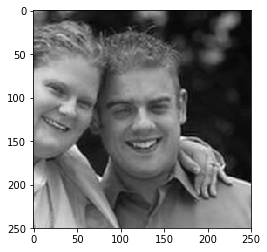

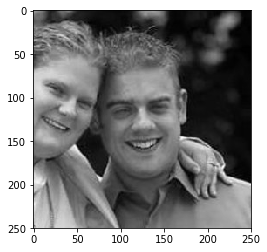

In [ ]:
decoded_S_gray =np.empty(shape=[X_secret_test.shape[0],IMG_SHAPE,IMG_SHAPE,1])
for i,picture in enumerate(decoded_S):
    s_pred_A=picture[:,:,0]
    s_pred_H=picture[:,:,1]
    s_pred_V=picture[:,:,2]
    s_pred_D=picture[:,:,3]
    s_pred_s = idwt2((s_pred_A,(s_pred_H,s_pred_V,s_pred_D)),'dmey')#转换回空域灰度图
    s_pred_s = np.expand_dims(s_pred_s, axis=2)
    decoded_S_gray[i,:,:,:1] = s_pred_s[:,:,:1]
img1 =  np.zeros(shape=(IMG_SHAPE,IMG_SHAPE))
img1 = decoded_S_gray[1,:,:,0]
plt.imshow(img1,cmap ='gray')
plt.show()

img2 =  np.zeros(shape=(IMG_SHAPE,IMG_SHAPE))
img2 = X_secret_test[1,:,:,0]
plt.imshow(img2,cmap ='gray')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


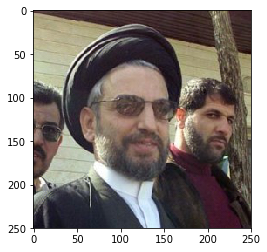

In [ ]:
decoded_C_rgb = np.empty(shape=(X_cover_test.shape[0],IMG_SHAPE,IMG_SHAPE,3))
decoded_C_b = np.empty(shape=[X_cover_test.shape[0],IMG_SHAPE,IMG_SHAPE,1])
for i,picture in enumerate(decoded_C):
    c_pred_A=picture[:,:,0]
    c_pred_H=picture[:,:,1]
    c_pred_V=picture[:,:,2]
    c_pred_D=picture[:,:,3]
    c_pred_s = idwt2((c_pred_A,(c_pred_H,c_pred_V,c_pred_D)),'dmey')#转换回空域L通道值
    c_pred_s = np.expand_dims(c_pred_s, axis=2)
    decoded_C_b[i,:,:,:1] = c_pred_s[:,:,:1]
    
decoded_C_rgb[:,:,:,0] = X_cover_test[:,:,:,0]
decoded_C_rgb[:,:,:,1] = X_cover_test[:,:,:,1]
decoded_C_rgb[:,:,:,2] = decoded_C_b[:,:,:,0] 

plt.imshow(decoded_C_rgb[10])
plt.show()

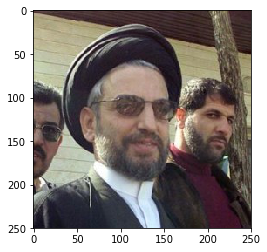

In [ ]:
plt.imshow(X_cover_test[10])
plt.show()

In [ ]:

print("X_cover range："+str(X_cover_test.min())+"-"+str(X_cover_test.max()))
print("decoder_cover range:"+str(decoded_C_rgb.min())+"-"+str(decoded_C_rgb.max()))
print("decoder_secret range:"+str(decoded_S_gray.min())+"-"+str(decoded_S_gray.max()))
print("X_secret range："+str(X_secret_test.min())+"-"+str(X_secret_test.max()))

X_cover取值范围：0.0-1.0
decoder_cover取值范围:-0.060525563975472624-1.1025517970609797
decoder_secret取值范围:-0.07355597615242004-1.1537574529647827
X_secret取值范围：0.0-1.0


In [ ]:
S_error, C_error = pixel_errors(X_secret_test*255, X_cover_test*255, decoded_S_gray*255, decoded_C_rgb*255)
print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 3.301807341344567
C error per pixel [0, 255]: 0.6610791897199803


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


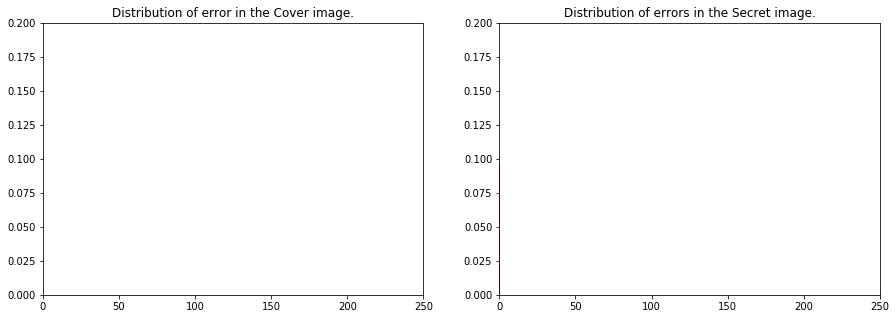

In [ ]:
# Plot distribution of errors in cover and secret images.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - X_cover_b2) 
pixel_histogram(diff_S, diff_C)

In [ ]:
def psnr(target_data, ref_data):
    target_data = np.float64(target_data)
    ref_data = np.float64(ref_data)
    mse = np.mean( (target_data - ref_data) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
import math
#[0,1]
img_s =  X_secret_test
img_s_pred = decoded_S_gray
print(np.shape(img_s_pred))
print(np.shape(img_s))
PSNR_S = psnr(img_s_pred,img_s)
print("PSNR_S:"+str(PSNR_S))

img_c_r = X_cover_test[:,:,:,0:1]
img_c_pred_r = decoded_C_rgb[:,:,:,0:1]
img_c_g = X_cover_test[:,:,:,1:2]
img_c_pred_g = decoded_C_rgb[:,:,:,1:2]
img_c_b = X_cover_test[:,:,:,2:3]
img_c_pred_b = decoded_C_rgb[:,:,:,2:3]
PSNR_C = (psnr(img_c_pred_r,img_c_r)+psnr(img_c_pred_g,img_c_g)+psnr(img_c_pred_b,img_c_b))/3
print("PSNR_C:"+str(PSNR_C))

(200, 250, 250, 1)
(200, 250, 250, 1)
PSNR_S:37.75576907831622
PSNR_C:82.31817396601987


In [ ]:
print("PSNR_Cb:"+str(psnr(img_c_pred_b,img_c_b)))

PSNR_Cb:46.95452189805959


In [ ]:
SSIM_C_M=[]
SSIM_S_M=[]

for i in range(0,200):
    img1=X_cover_test[i]
    img_c=decoded_C_rgb[i]
    img2=X_secret_test[i]
    img_s=decoded_S_gray[i]
    SSIM_C =skimage.measure.compare_ssim(X_cover_test[i]*255, decoded_C_rgb[i]*255, data_range=255, multichannel=True)
    SSIM_S =skimage.measure.compare_ssim(X_secret_test[i], decoded_S_gray[i], data_range=255, multichannel=True)
    SSIM_C_M.append(SSIM_C)
    SSIM_S_M.append(SSIM_S)
    
SSIM_C_M = np.mean(SSIM_C_M)
SSIM_S_M = np.mean(SSIM_S_M)
print("SSIM_C:"+str(SSIM_C_M))

print("SSIM_S:"+str(SSIM_S_M))



SSIM_C:0.8954524990984629
SSIM_S:0.9808342647527784


In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = True
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image_gray(img, n_rows, n_col, idx, gray=True, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)

    c_pred_A=img[:,:,0]
    c_pred_H=img[:,:,1]
    c_pred_V=img[:,:,2]
    c_pred_D=img[:,:,3]
    image = idwt2((c_pred_A,(c_pred_H,c_pred_V,c_pred_D)),'dmey')
    image = np.expand_dims(image, axis=2)
    image = np.concatenate((image, image, image), axis=-1)
    if gray:
        plt.imshow(rgb2gray(image), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

def show_image_rgb(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    img1 = img / 255
    ax = plt.subplot(n_rows, n_col, idx)   
    if gray:
        plt.imshow(rgb2gray(img1), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)
        
def show_image_lab(img,img_lab, n_rows, n_col, idx, gray=False, first_row=False, title=None):

    ax = plt.subplot(n_rows, n_col, idx)   
    c_pred_A=img[:,:,0]
    c_pred_H=img[:,:,1]
    c_pred_V=img[:,:,2]
    c_pred_D=img[:,:,3]

    c_pred_l = idwt2((c_pred_A,(c_pred_H,c_pred_V,c_pred_D)),'dmey')
    c_lab = np.zeros(shape=(IMG_SHAPE,IMG_SHAPE,3))
    c_lab[:,:,0] = c_pred_l
    c_lab[:,:,1] = img_lab[:,:,1]
    c_lab[:,:,2] = img_lab[:,:,2]
    img = color.lab2rgb(c_lab)
    #imageio.imwrite('out1/LAB_high_C_%s.bmp'%idx, img)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)
        
        
plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4

    show_image_rgb(X_cover[idx], n, n_col, i * n_col + 1, gray=False, first_row=i==0, title='Cover')
    
    show_image_gray(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
        
    show_image_lab(decoded_C[idx],X_cover_lab[idx], n, n_col, i * n_col + 3, gray=False, first_row=i==0, title='Encoded Cover')
    
    show_image_gray(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image_gray(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')    
        show_image_gray(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()